In [1]:
from gmvae_final import GMVAE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, balanced_accuracy_score
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
M = 13
K = 19
D = 16
mymodel = GMVAE(M, K, D, 8, 0.2, 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mymodel.load_state_dict(torch.load("wandb_follow/GMVAE_BMMC_FINETUNED_supervised_final.pt", weights_only = True))
mymodel.to(device)

GMVAE(
  (q_c_x): ResidualNetwork(
    (blocks): ModuleList(
      (0): ResidualBlock(
        (net): Sequential(
          (0): Linear(in_features=13, out_features=104, bias=True)
          (1): ReLU()
          (2): Linear(in_features=104, out_features=104, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (shortcut): Linear(in_features=13, out_features=104, bias=True)
      )
      (1): ResidualBlock(
        (net): Sequential(
          (0): Linear(in_features=104, out_features=104, bias=True)
          (1): ReLU()
          (2): Linear(in_features=104, out_features=104, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (shortcut): Identity()
      )
      (2): Linear(in_features=104, out_features=19, bias=True)
    )
  )
  (q_z_cx): Sequential(
    (0): Concat(
      (projs): ModuleList(
        (0): Linear(in_features=19, out_features=16, bias=True)
        (1): Linear(in_features=13, out_features=16, bias=True)
      )
    )
    (1

In [2]:

cluster_labels = {
    0: "CD11b- Monocyte",
    1: "CD11bhi Monocyte",
    2: "CMP",
    3: "GMP",
    4: "HSC",
    5: "Immature B",
    6: "MEP",
    7: "MPP",
    8: "Mature CD38lo B",
    9: "Mature CD38mid B",
    10: "Mature CD4+ T",
    11: "Mature CD8+ T",
    12: "NK",
    13: "Naive CD4+ T",
    14: "Naive CD8+ T",
    15: "Plasma cell",
    16: "Plasmacytoid DC",
    17: "Pre-B I",
    18: "Pre-B II"
}
"""

cluster_labels = {
    0: "Mature CD4+ T",
    1: "Mature CD8+ T",
    2: "Naive CD4+ T",
    3: "Naive CD8+ T"
}

cluster_labels = {
    0: "Mature CD8+ T",
    1: "Naive CD8+ T"
}

cluster_labels = {
    0: "Basophils",
    1: "CD16+ NK cells",
    2: "CD16- NK cells",
    3: "CD34+CD38+CD123+ HSPCs",
    4: "CD34+CD38+CD123- HSPCs",
    5: "CD34+CD38lo HSCs",
    6: "CD4 T cells",
    7: "CD8 T cells",
    8: "Mature B cells",
    9: "Monocytes",
    10: "Plasma B cells",
    11: "Pre B cells",
    12: "Pro B cells",
    13: "pDCs"
}
"""
sns.set_style("darkgrid")
colors = sns.color_palette('tab20', n_colors=len(cluster_labels))
tick_positions = [i + 0.5 for i in range(len(cluster_labels))]
bounds = range(len(cluster_labels) + 1)
lighter_colors = ListedColormap([(np.array(c) * 0.6 + 0.4) for c in colors])
norm = BoundaryNorm(bounds, len(colors)) 

In [3]:
root = './scyan_datasets/bmmc/bmmc_true.csv'
df = pd.read_csv(root)

In [4]:
import pandas as pd
c = pd.factorize(df['label'], sort = True)[0] 
marker_names = df.columns[:-1]
x = df.iloc[:, :M]  

x_all = torch.tensor(x.values, dtype=torch.float32) 
c_all = torch.tensor(c, dtype=torch.long) 

allset = torch.utils.data.TensorDataset(x_all, c_all)

dataloader = DataLoader(allset, 2000, shuffle=True)

In [10]:
x, c_true = next(iter(dataloader))
x = x.to(mymodel.device)
c_true = c_true.to(mymodel.device)

q_c_x = F.softmax(mymodel.q_c_x(x), dim=-1)
c = torch.multinomial(q_c_x, 1, replacement=True).squeeze() 

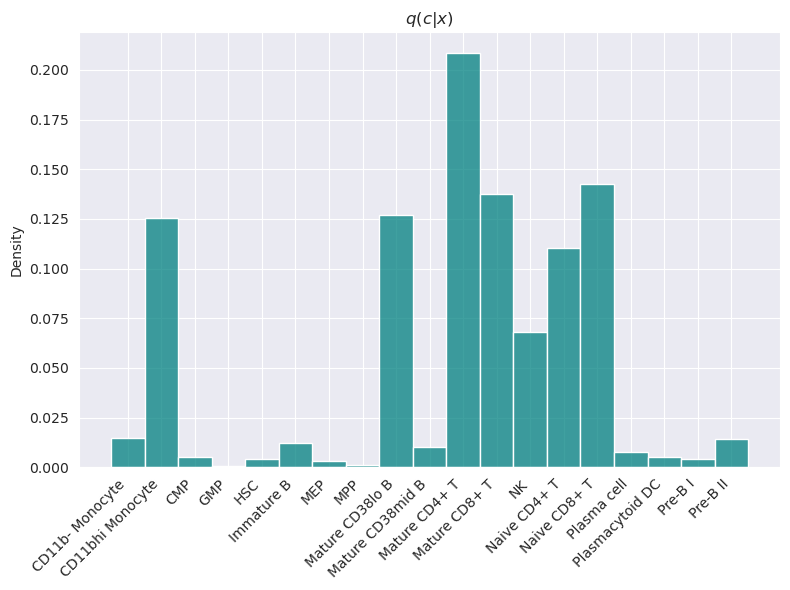

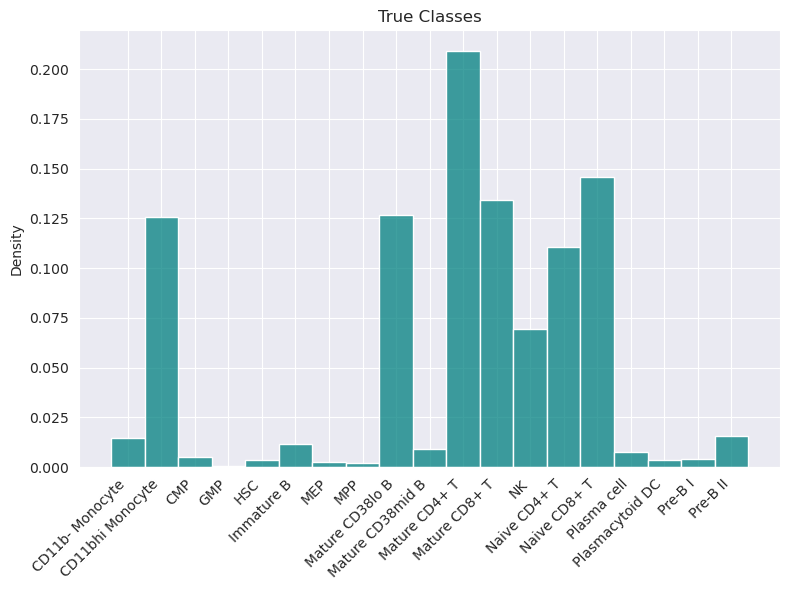

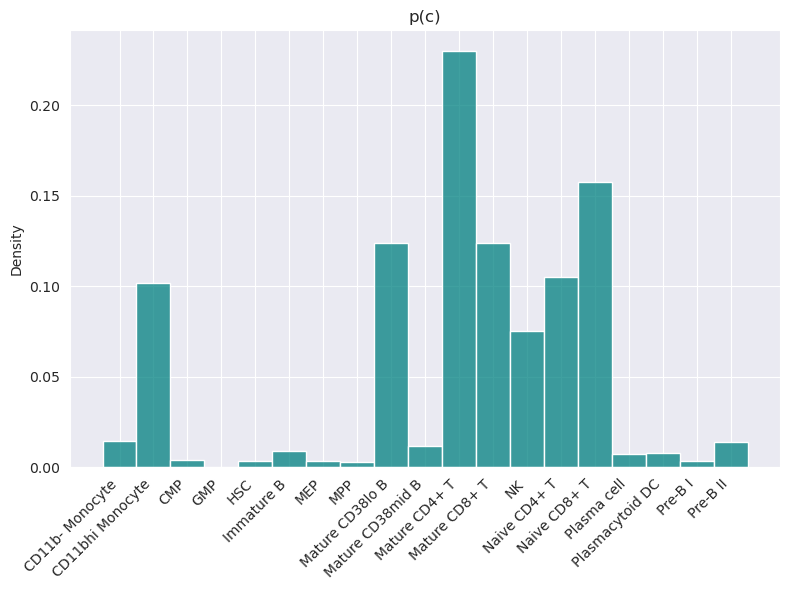

In [11]:
plt.figure(figsize = (8,6))
sns.histplot(c.cpu().numpy(), bins=len(cluster_labels), kde=False, stat="density", color="teal", discrete = True)
plt.title(r"$q(c|x)$")
plt.ylabel("Density")
plt.xticks(range(len(cluster_labels)), labels=[cluster_labels[i] for i in range(len(cluster_labels))], rotation=45, ha = "right")
plt.tight_layout()
plt.show()

plt.figure(figsize = (8,6))
sns.histplot(c_true.cpu().numpy(), bins=len(cluster_labels), kde=False, stat="density", color="teal", discrete = True)
plt.title("True Classes")
plt.ylabel("Density")
plt.xticks(range(len(cluster_labels)), labels=[cluster_labels[i] for i in range(len(cluster_labels))], rotation=45, ha = "right")
plt.tight_layout()
plt.show()

p_c = F.softmax(mymodel.p_c, dim = 0)
pc = torch.multinomial(p_c, 2000, replacement = True)
codes_pc = mymodel.one_hot(pc, mymodel.K)
plt.figure(figsize = (8,6))
sns.histplot(pc.cpu().numpy(), bins=len(cluster_labels), kde=False, stat="density", color="teal", discrete = True)
plt.title("p(c)")
plt.ylabel("Density")
plt.xticks(range(len(cluster_labels)), labels=[cluster_labels[i] for i in range(len(cluster_labels))], rotation=45, ha = "right")
plt.tight_layout()
plt.show()

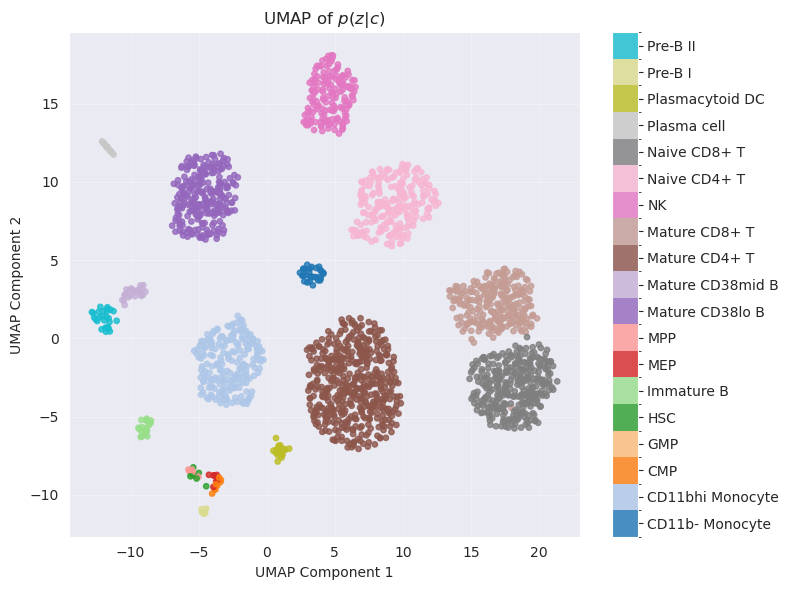

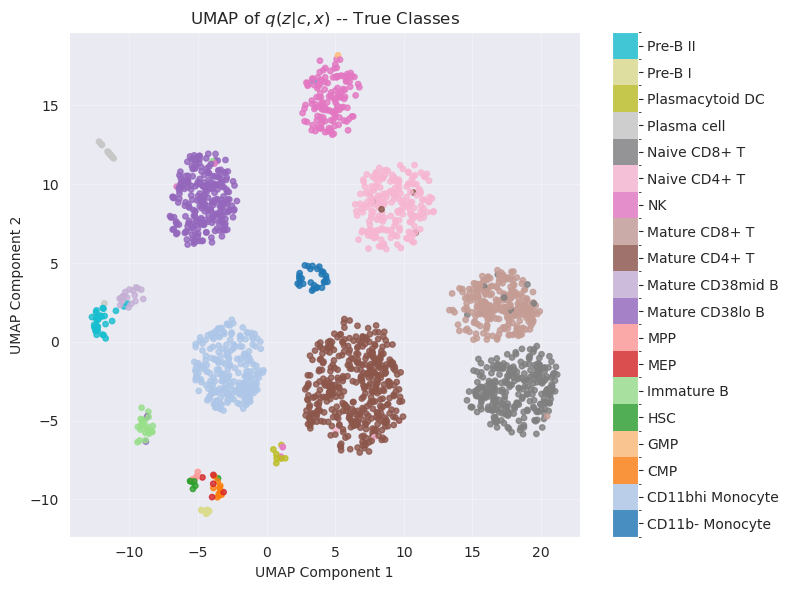

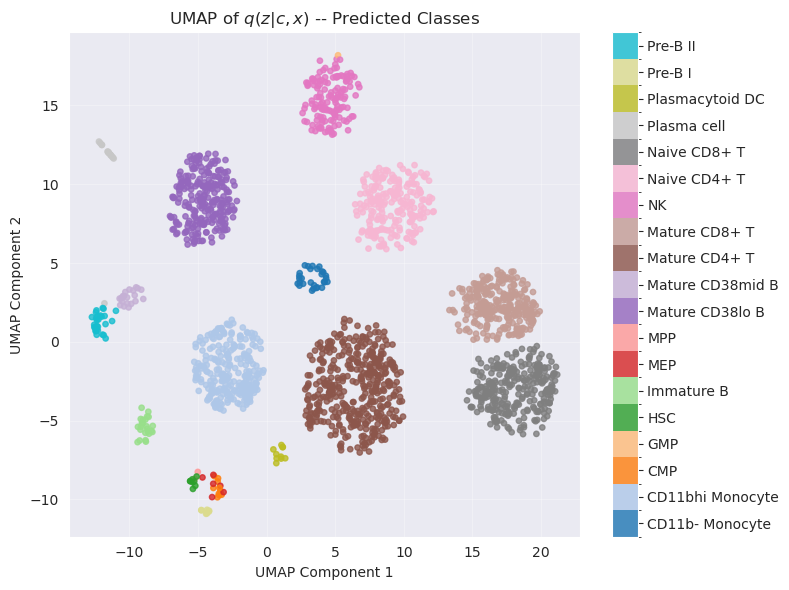

In [14]:
import umap.umap_ as umap
sns.set_style("darkgrid")
reducer = umap.UMAP(n_components=2, min_dist=0.8, n_neighbors = 8)
p_z = mymodel.p_z_c(codes_pc).to(device)
z_c = p_z[:, :mymodel.D] + p_z[:, mymodel.D:].exp() ** 0.5 * torch.randn(2000, D, device = device)

zc = reducer.fit_transform(z_c.detach().cpu().numpy())
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    zc[:, 0],
    zc[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in pc.cpu().numpy()],
    cmap=ListedColormap(colors),
    norm=norm,
    s=15,
    alpha=0.8
)
colorbar = plt.colorbar(scatter, ticks=np.arange(len(cluster_labels)), boundaries = bounds)
colorbar.set_ticks(tick_positions)
colorbar.ax.set_yticklabels(cluster_labels.values())
plt.title(r"UMAP of $p(z|c)$")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/presentation/p_z_c.png", dpi=150)
plt.show()
plt.close()


codes = mymodel.one_hot(c, mymodel.K)
q_z_cx = mymodel.q_z_cx([codes, x])
mu_z = q_z_cx[:, :mymodel.D]
logvar_z = q_z_cx[:, mymodel.D:]
z = mu_z + logvar_z.exp().sqrt() * torch.randn_like(mu_z)

zt = reducer.transform(z.detach().cpu().numpy())
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    zt[:, 0],
    zt[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in c_true.cpu().numpy()],
    cmap=ListedColormap(colors),
    norm=norm,
    s=15,
    alpha=0.8
)
colorbar = plt.colorbar(scatter, ticks=np.arange(len(cluster_labels)), boundaries = bounds)
colorbar.set_ticks(tick_positions)
colorbar.ax.set_yticklabels(cluster_labels.values())
plt.title(r"UMAP of $q(z|c, x)$ -- True Classes")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/presentation/q_z_cx_known.svg", dpi=150)
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    zt[:, 0],
    zt[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in c.cpu().numpy()],
    cmap=ListedColormap(colors),
    norm=norm,
    s=15,
    alpha=0.8
)
colorbar = plt.colorbar(scatter, ticks=np.arange(len(cluster_labels)), boundaries = bounds)
colorbar.set_ticks(tick_positions)
colorbar.ax.set_yticklabels(cluster_labels.values())
plt.title(r"UMAP of $q(z|c, x)$ -- Predicted Classes")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/presentation/q_z_cx_known_2.png", dpi=150)
plt.show()
plt.close()



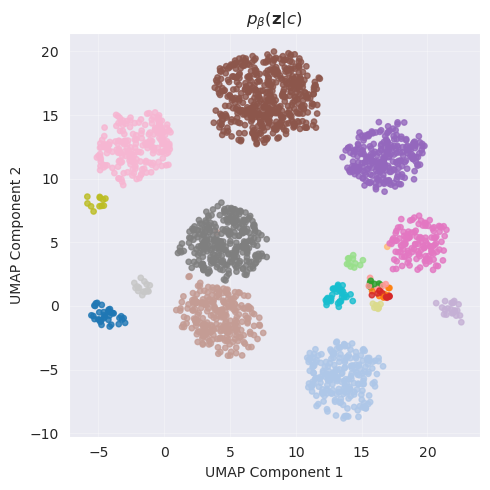

In [9]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(
    zc[:, 0],
    zc[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in pc.cpu().numpy()],
    cmap=ListedColormap(colors),
    norm=norm,
    s=15,
    alpha=0.8
)
plt.title(r"$p_{\beta}(\mathbf{z}|c)$")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/presentation/PC.svg", dpi=150)
plt.show()
plt.close()

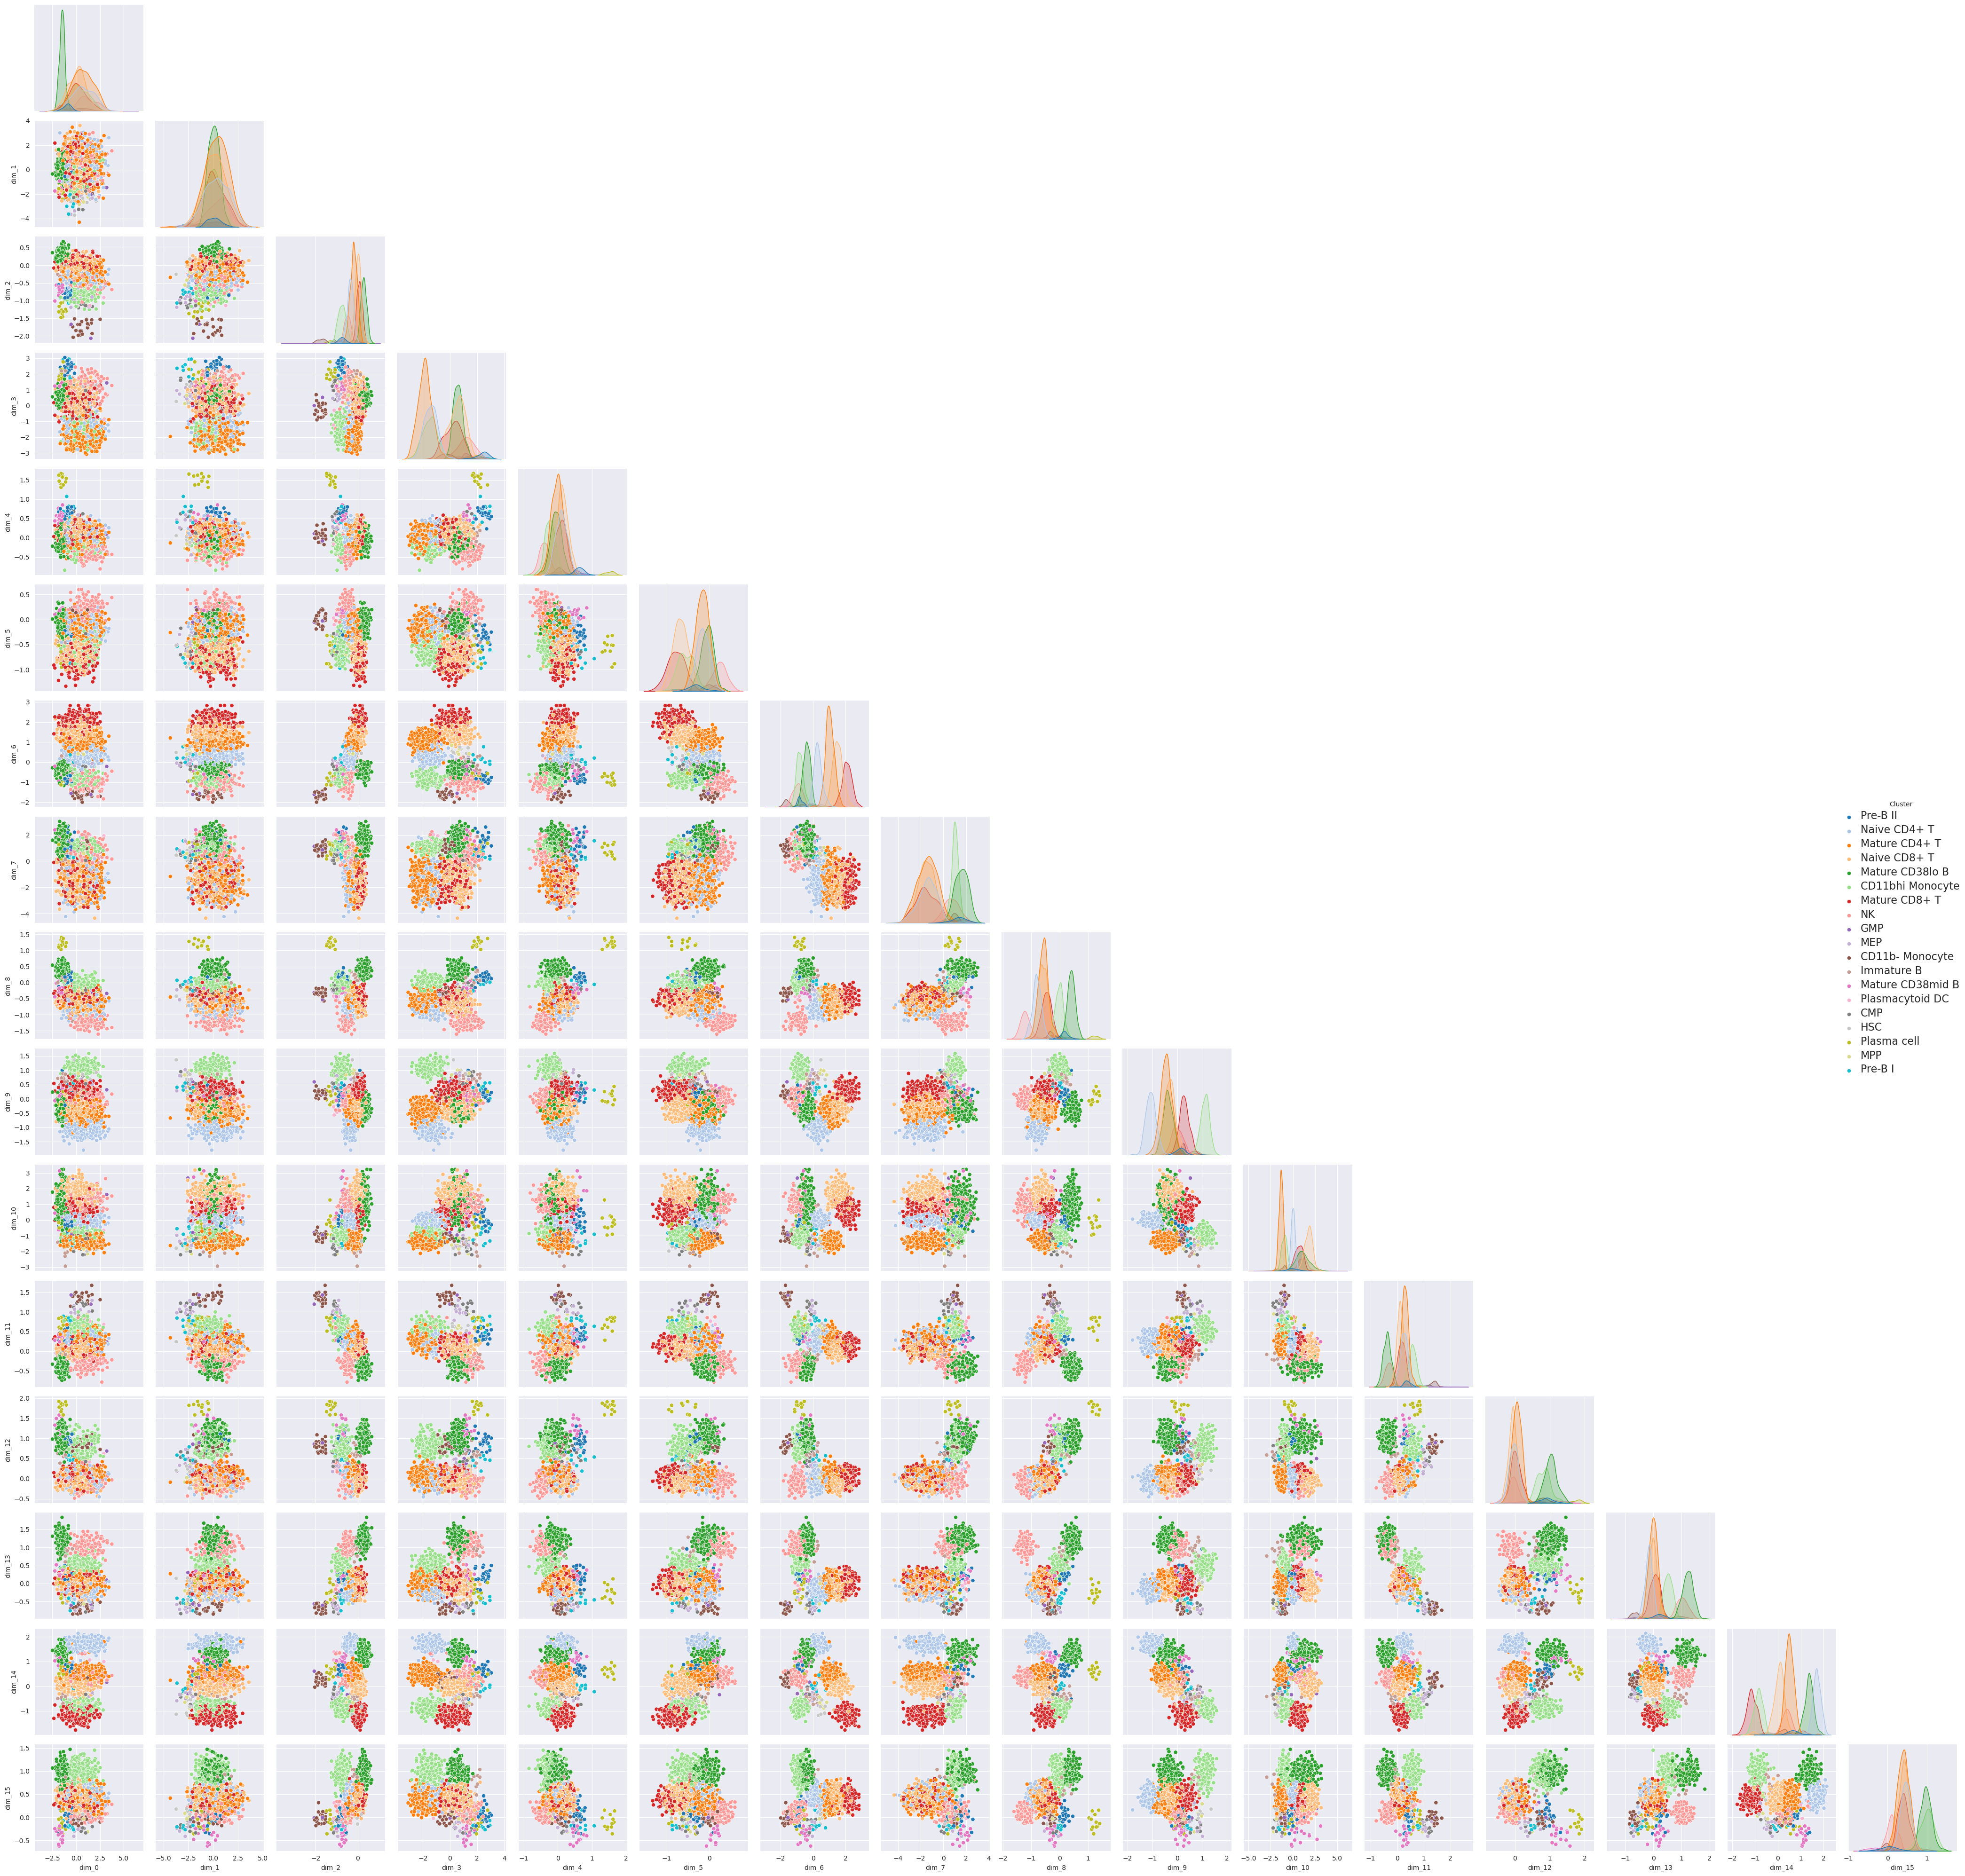

In [9]:
import warnings
warnings.simplefilter("ignore")
df = pd.DataFrame(z.detach().cpu().numpy(), columns=[f"dim_{i}" for i in range(z.shape[1])])
df["Cluster"] = [cluster_labels[label] for label in c_true.cpu().numpy()]

plot = sns.pairplot(df, hue="Cluster", corner=True, palette=colors)
legend = plot.legend
for text in legend.get_texts():
    text.set_fontsize(16)
plt.tight_layout()
plt.savefig("figures/presentation/pairplot.png", dpi=250)
plt.show()


In [12]:
p_x_z = mymodel.p_x_z(z)
x_recon = p_x_z[:, :M] + p_x_z[:, M:].exp() ** 0.5 * torch.randn(len(x), M, device = device)

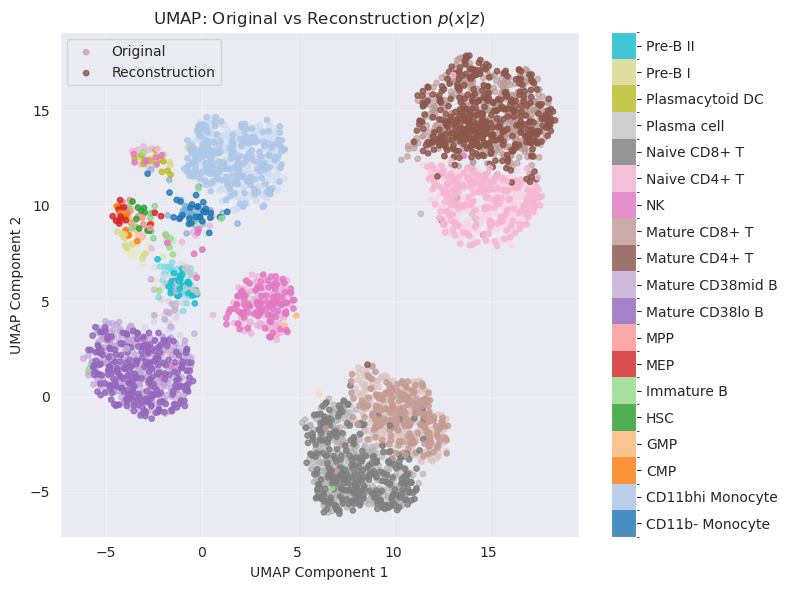

In [13]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib as mp
sns.set_style("darkgrid")


reducer = umap.UMAP(n_components=2, min_dist=0.8, n_neighbors = 8)
embedding_original = reducer.fit_transform(x.cpu().numpy())
embedding_recon = reducer.transform(x_recon.detach().cpu().numpy())

plt.figure(figsize=(8, 6))

scatter_original = plt.scatter(
    embedding_original[:, 0],
    embedding_original[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in c_true.cpu().numpy()],
    cmap=lighter_colors,
    norm=norm,
    s=15,
    alpha=0.6,  
    label="Original"
)

scatter_recon = plt.scatter(
    embedding_recon[:, 0],
    embedding_recon[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in c_true.cpu().numpy()],
    cmap=ListedColormap(colors),
    norm=norm,
    s=15,
    alpha=0.8,
    label="Reconstruction"
)

colorbar = plt.colorbar(scatter_recon, ticks=np.arange(len(cluster_labels)), boundaries = bounds)
colorbar.set_ticks(tick_positions)
colorbar.ax.set_yticklabels(cluster_labels.values())

plt.title(r"UMAP: Original vs Reconstruction $p(x|z)$")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(alpha=0.3)
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig("umap_reconstruction.png", dpi=150)
plt.show()
plt.close()

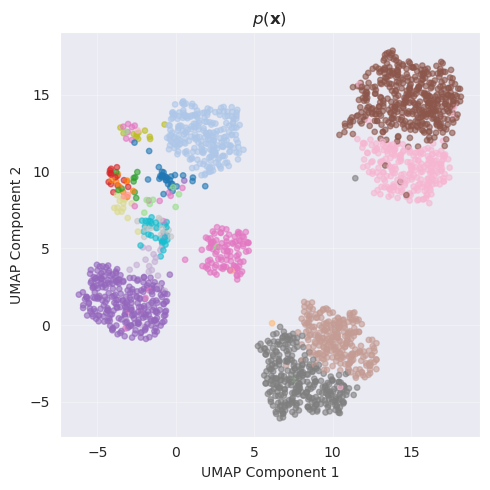

In [15]:
plt.figure(figsize=(5, 5))
scatter_original = plt.scatter(
    embedding_original[:, 0],
    embedding_original[:, 1],
    c=[list(cluster_labels.keys()).index(label) for label in c_true.cpu().numpy()],
    cmap=ListedColormap(colors),
    norm=norm,
    s=15,
    alpha=0.6,  
    label="Original"
)
plt.title(r"$p(\mathbf{x})$")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/presentation/PX.svg", dpi=150)
plt.show()
plt.close()